In [1]:
!pip install tensorflow==2.9.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as np
from tabulate import tabulate
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sbn

In [3]:
tf.__version__

'2.9.1'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.listdir("/content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes")

['efficientv2.ipynb']

In [68]:
def plot_hist(history):
    plt.figure(figsize=(7, 7))

    plt.subplot(2, 1, 1)
    plt.plot(history["accuracy"], label='Training Accuracy')
    plt.plot(history["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.5,1.0])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(history["loss"], label='Training Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [8]:
def plot_total_hist(history1, history2, fine_tunning_epoch):
    initial_epochs = fine_tunning_epoch
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1["accuracy"] + history2["accuracy"], label='Training Accuracy')
    plt.plot(history1["val_accuracy"] + history2["val_accuracy"], label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1["loss"] + history2["loss"], label='Training Loss')
    plt.plot(history1["val_loss"] + history2["val_loss"], label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [42]:
def get_history_stats(history):
    print(f"Accuracy: {max(history['accuracy']):.{4}f}")
    print(f"Validation accuracy: {max(history['val_accuracy']):.{4}f}")
    print(f"Loss: {min(history['loss']):.{4}f}")
    print(f"Validation loss : {min(history['val_loss']):.{4}f}")    

In [11]:
def model_table(model):
    header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
    data = [[]]
    total_layers = 0
    total_trainable = 0
    total_no_trainable = 0
    for i, layer in enumerate(model.layers):
        if layer.__class__.__name__.lower() == "functional":
            data.append([i+1, layer.name, layer.input_shape, layer.output_shape, layer.trainable])
        else:
            data.append([i+1, layer.__class__.__name__, layer.input_shape, layer.output_shape, layer.trainable])
        if layer.trainable:
            total_trainable += 1
        else:
            total_no_trainable += 1
    print(tabulate(data, headers=header, colalign="c", tablefmt="github"))
    print("\n--------------------------------------------------")
    print("Total layer: ", total_trainable + total_no_trainable)
    print("Tainable layers: ", total_trainable)
    print("Non trainable layers: ", total_no_trainable)

In [12]:
def model_info(model, verbose=0):
   layer_info = []
   header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
   data = [[]]
   trainable_layers, non_trainable_layers = 0, 0
   trainable_params, non_trainable_params = 0, 0
   for i, layer in enumerate(model.layers):
      layer_name = layer.name
      input_shape = layer.input_shape[1:]
      output_shape = layer.output_shape[1:]
      trainable = layer.trainable
      layer_type = type(layer).__name__
      data.append([i, layer_type if layer_type != "Functional" else layer.name, input_shape, output_shape, trainable])
      layer_params = np.sum([np.prod(p.shape) for p in layer.weights])
      if trainable:
         trainable_params += layer_params
         trainable_layers += 1
      else:
         non_trainable_params += layer_params
         non_trainable_layers += 1
   print("=========================================================")
   print(f"Total params: {int(trainable_params + non_trainable_params):,}")
   print(f"Trainable params: {int(trainable_params):,}")
   print(f"Non-trainable params: {int(non_trainable_params):,}")
   print(f"Total layers: {len(model.layers):,}")
   print(f"Trainable layers: {trainable_layers:,}")
   print(f"Non-trainable params: {non_trainable_layers:,}")
   print("=========================================================")
   if verbose == 1:
      print(tabulate(data, headers=header, colalign="c", tablefmt="github"))


In [13]:
PATH = "/content/drive/MyDrive/Datasets/data"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 21
Number of train batches: 83


In [15]:
callbacks_path = "/content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/eficientnet_models/"
model_name = callbacks_path + "best_model.h5"
fine_model_name = callbacks_path + "best_model_fine.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

fine_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fine_model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

In [16]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, 
                                                     weights="imagenet", 
                                                     input_shape=IMG_SHAPE)

In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.25),
], name="data_augmentation")
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [20]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 1e-5

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [45]:
model_info(base_model)

Total params: 4,049,571
Trainable params: 1,454,560
Non-trainable params: 2,595,011
Total layers: 238
Trainable layers: 20
Non-trainable params: 218


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [24]:
model_info(model, verbose=1)

Total params: 36,163,236
Trainable params: 32,113,665
Non-trainable params: 4,049,571
Total layers: 7
Trainable layers: 6
Non-trainable params: 1
|   Number | Name           | Input_shape   | Output_shape   | Trainable   |
|----------|----------------|---------------|----------------|-------------|
|          |                |               |                |             |
| 0        | InputLayer     | []            | []             | True        |
| 1        | Sequential     | (224, 224, 3) | (224, 224, 3)  | True        |
| 2        | efficientnetb0 | (224, 224, 3) | (7, 7, 1280)   | False       |
| 3        | Flatten        | (7, 7, 1280)  | (62720,)       | True        |
| 4        | Dense          | (62720,)      | (512,)         | True        |
| 5        | Dropout        | (512,)        | (512,)         | True        |
| 6        | Dense          | (512,)        | (1,)           | True        |


In [25]:
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset, 
    callbacks=[model_checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


83/83 [==============================] - ETA: 0s - loss: 3.3864 - accuracy: 0.7611
Epoch 1: val_accuracy improved from -inf to 0.82576, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/eficientnet_models/best_model.h5
83/83 [==============================] - 32s 238ms/step - loss: 3.3864 - accuracy: 0.7611 - val_loss: 0.4220 - val_accuracy: 0.8258
Epoch 2/20
82/83 [============================>.] - ETA: 0s - loss: 0.3963 - accuracy: 0.8369
Epoch 2: val_accuracy improved from 0.82576 to 0.86515, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/eficientnet_models/best_model.h5
83/83 [==============================] - 19s 223ms/step - loss: 0.3951 - accuracy: 0.8373 - val_loss: 0.3557 - val_accuracy: 0.8652
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8502
Epoch 3: val_accuracy did not improve from 0.86515
83/83 [==============================] - 16s 185ms/step - loss: 0.3515 - accuracy: 

In [26]:
print(history.history)

{'loss': [3.3863525390625, 0.39507347345352173, 0.3514711260795593, 0.3551783263683319, 0.34219714999198914, 0.324652761220932, 0.30602264404296875, 0.3143611252307892, 0.3064950704574585, 0.2814941704273224, 0.2651287615299225, 0.25863149762153625, 0.2576637864112854, 0.2751864194869995, 0.24725815653800964, 0.23616693913936615, 0.23111245036125183, 0.23331794142723083, 0.24288462102413177, 0.23748694360256195], 'accuracy': [0.7610921263694763, 0.8373151421546936, 0.850208580493927, 0.852483868598938, 0.8585513830184937, 0.8577929735183716, 0.8661357760429382, 0.8627228140830994, 0.8619643449783325, 0.8763746619224548, 0.8809252977371216, 0.8881304264068604, 0.8828213810920715, 0.8775123357772827, 0.8839590549468994, 0.896094024181366, 0.896094024181366, 0.891922652721405, 0.8907849788665771, 0.8968524932861328], 'val_loss': [0.4219788610935211, 0.3556833863258362, 0.3561176657676697, 0.3470224142074585, 0.3248378038406372, 0.30215978622436523, 0.2970924973487854, 0.37531158328056335,

In [27]:
base_model.trainable = True

In [47]:
fine_layer_unfrize = 50

In [48]:
for i, layer in enumerate(base_model.layers[:-fine_layer_unfrize]):
    layer.trainable = False
for i, layer in enumerate(base_model.layers[-fine_layer_unfrize:]):
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            layer.trainable = False

In [49]:
model_info(base_model, verbose=1)

Total params: 4,049,571
Trainable params: 1,454,560
Non-trainable params: 2,595,011
Total layers: 238
Trainable layers: 20
Non-trainable params: 218
|   Number | Name                   | Input_shape           | Output_shape   | Trainable   |
|----------|------------------------|-----------------------|----------------|-------------|
|          |                        |                       |                |             |
| 0        | InputLayer             | []                    | []             | False       |
| 1        | Rescaling              | (224, 224, 3)         | (224, 224, 3)  | False       |
| 2        | Normalization          | (224, 224, 3)         | (224, 224, 3)  | False       |
| 3        | TFOpLambda             | (224, 224, 3)         | (224, 224, 3)  | False       |
| 4        | ZeroPadding2D          | (224, 224, 3)         | (225, 225, 3)  | False       |
| 5        | Conv2D                 | (225, 225, 3)         | (112, 112, 32) | False       |
| 6        | B

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [52]:
fine_epochs = 20
fine_history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs + fine_epochs,
    initial_epoch=history.epoch[-1], callbacks=[fine_model_checkpoint],
    verbose = 1)

Epoch 20/40


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


83/83 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9154
Epoch 20: val_accuracy did not improve from 0.86212
83/83 [==============================] - 25s 199ms/step - loss: 0.1991 - accuracy: 0.9154 - val_loss: 0.3123 - val_accuracy: 0.8591
Epoch 21/40
83/83 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9006
Epoch 21: val_accuracy did not improve from 0.86212
83/83 [==============================] - 18s 206ms/step - loss: 0.2135 - accuracy: 0.9006 - val_loss: 0.3106 - val_accuracy: 0.8576
Epoch 22/40
83/83 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9086
Epoch 22: val_accuracy did not improve from 0.86212
83/83 [==============================] - 16s 186ms/step - loss: 0.1932 - accuracy: 0.9086 - val_loss: 0.3109 - val_accuracy: 0.8576
Epoch 23/40
83/83 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9094
Epoch 23: val_accuracy did not improve from 0.86212
83/83 [=====================

In [53]:
print(fine_history.history)

{'loss': [0.19906559586524963, 0.21345572173595428, 0.19323720037937164, 0.2065100073814392, 0.20107412338256836, 0.19630417227745056, 0.20059441030025482, 0.20337584614753723, 0.19726793467998505, 0.19737885892391205, 0.19373364746570587, 0.1875043511390686, 0.19355158507823944, 0.19695739448070526, 0.2048930823802948, 0.19411197304725647, 0.1948384940624237, 0.19289568066596985, 0.1889985352754593, 0.19100937247276306, 0.19934450089931488], 'accuracy': [0.9154341816902161, 0.9006446599960327, 0.9086082577705383, 0.9093667268753052, 0.9014031291007996, 0.914675772190094, 0.9055745005607605, 0.9070913791656494, 0.914296567440033, 0.9089874625205994, 0.9093667268753052, 0.9116420149803162, 0.9097459316253662, 0.9112628102302551, 0.912400484085083, 0.914675772190094, 0.9116420149803162, 0.9116420149803162, 0.9108836054801941, 0.9131588935852051, 0.9120212197303772], 'val_loss': [0.31225499510765076, 0.3105727732181549, 0.310918390750885, 0.31090137362480164, 0.30857545137405396, 0.308730

In [54]:
get_history_stats(history.history)

Accuracy: 0.8969
Validation accuracy: 0.8788
Loss: 0.2311
Validation loss : 0.2971


In [55]:
get_history_stats(fine_history.history)

Accuracy: 0.9154
Validation accuracy: 0.8652
Loss: 0.1875
Validation loss : 0.3031


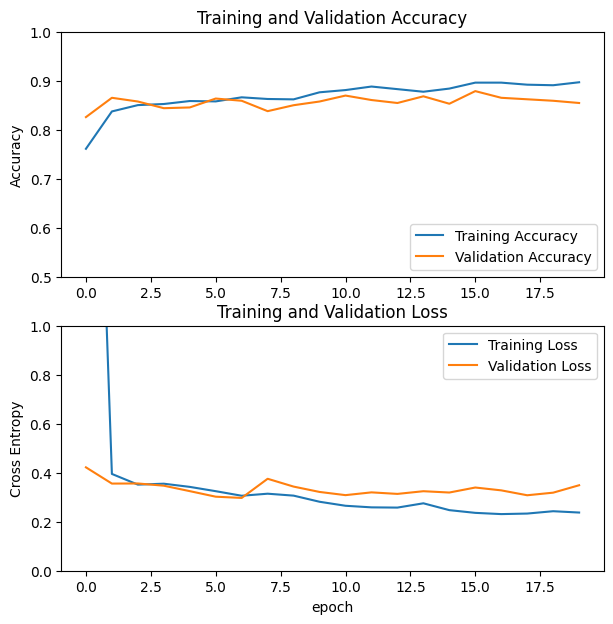

In [69]:
plot_hist(history.history)

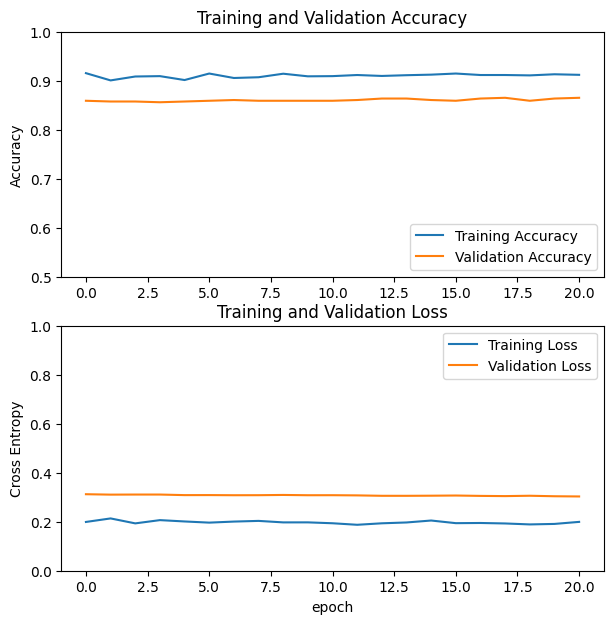

In [70]:
plot_hist(fine_history.history)

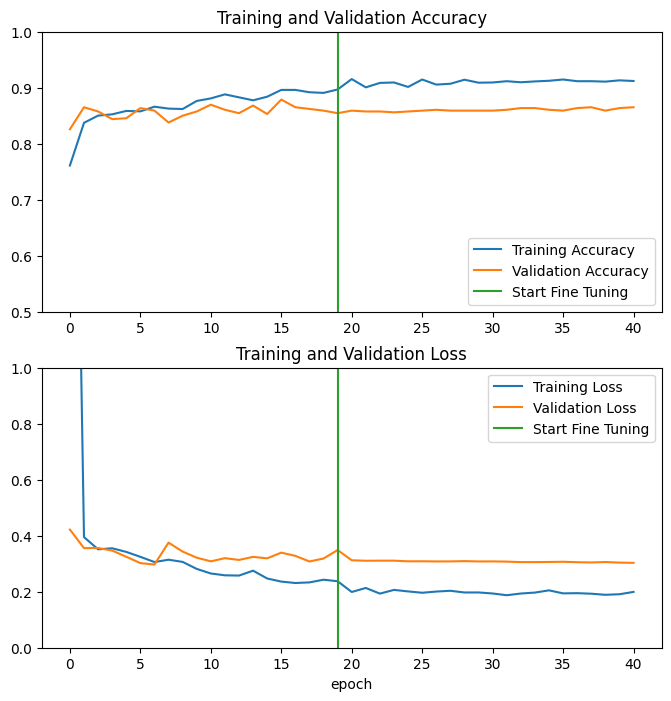

In [71]:
plot_total_hist(history.history, fine_history.history, fine_epochs)